In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

#for number crunching

import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data vicualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import seaborn as sns


In [2]:
#mport the data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]

# z-score all columns (including quality)
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [3]:
# convert from pandas dataframe to tensor
# first drop residual sugar

cols2zscore = cols2zscore.drop('residual sugar')

dataT = torch.tensor(data[cols2zscore].values).float()
sugar = torch.tensor(data['residual sugar'].values).float()
sugar  = sugar[:,None]


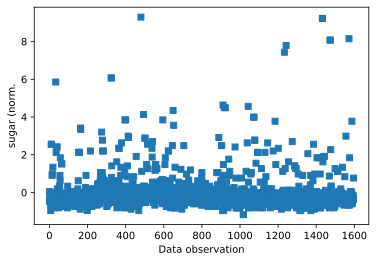

In [4]:
# check  values in sugar
plt.plot(sugar,'s')
plt.xlabel('Data observation')
plt.ylabel('sugar (norm.')
plt.show()

In [5]:
# use scikit learn to split the data
train_dataSK,test_dataSK,train_labelSK,test_labelSK = train_test_split(dataT,sugar,test_size=.1)

# then convert them into pytorch Datasets
train_dataDataset = torch.utils.data.TensorDataset(train_dataSK,train_labelSK)
test_dataDataset = torch.utils.data.TensorDataset(test_dataSK,test_labelSK)

# finally translate into DataLoader objects
batch_size = 32
train_loader = DataLoader(train_dataDataset,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [6]:
# create a class for the model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11,16)

        # hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # output layer
        self.output = nn.Linear(32,1)

        # forward pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu( self.fc1(x) )
        x = F.relu( self.fc2(x) )
        return self.output(x) 

In [7]:
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testLoss[epochi] = lossfun(yHat,y).item()
  
  # function output
  return trainLoss,testLoss

In [8]:
# create a model and train it
winenet = ANNwine()
trainLoss,testLoss = trainTheModel()

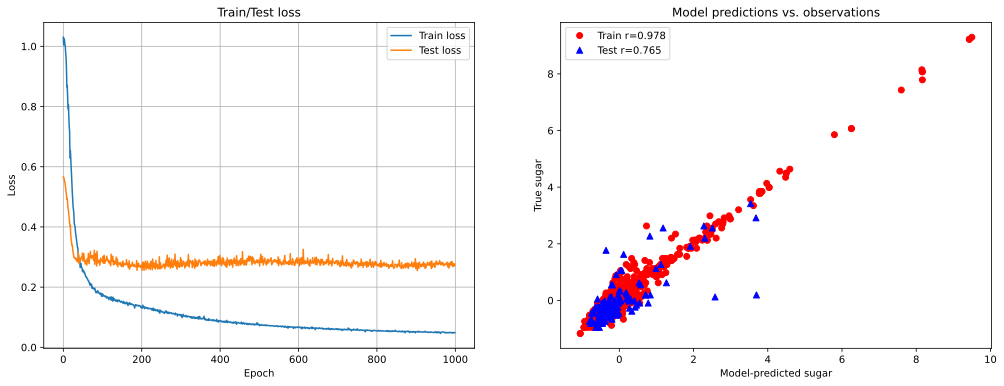

In [11]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = winenet(train_dataSK)
yHatTest  = winenet(test_dataSK)

ax[1].plot(yHatTrain.detach(),train_labelSK,'ro')
ax[1].plot(yHatTest.detach(),test_labelSK,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelSK.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelSK.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

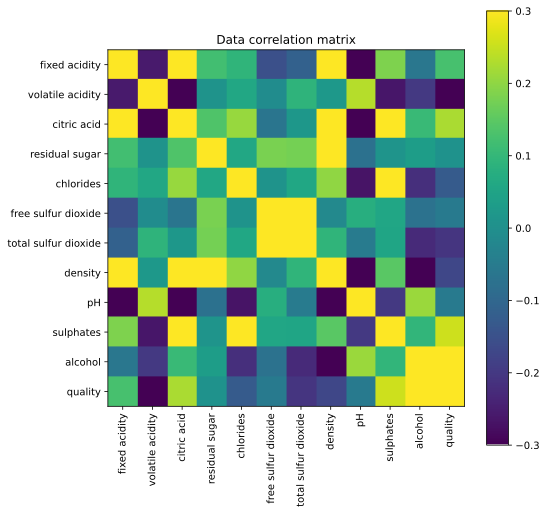

In [12]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()